In [ ]:
import numpy as np    # Numerical operations
import os             # OS file operations
import glob           # File pattern matching
from tqdm import tqdm # Progress bar
import cv2            # Image & video processing

In [ ]:
!pip install mediapipe  # Install MediaPipe library


In [ ]:
import mediapipe as mp  # Import MediaPipe library

mp_holistic = mp.solutions.holistic  # Shortcut for holistic module

# Initialize Holistic model for landmark detection on images
holistic_image = mp_holistic.Holistic(
    static_image_mode=True,        # Process static images
    model_complexity=2,            # Higher model complexity for better accuracy
    smooth_landmarks=True,         # Smooth landmark detection
    enable_segmentation=False,     # Disable segmentation mask
    refine_face_landmarks=False,   # No extra refinement for face landmarks
    min_detection_confidence=0.7,  # Minimum confidence for detection
    min_tracking_confidence=0.7    # Minimum confidence for tracking
)


In [ ]:
DATA_PATH = "./processed_keypoints"  # Output folder for keypoints
os.makedirs(DATA_PATH, exist_ok=True)  # Create folder if it doesn't exist

sequence_length = 30  # Number of frames per video sample


In [ ]:
def extract_keypoints_from_holistic(results) -> np.ndarray | None:
    """
    Flatten pose + left & right hand landmarks into a 225-dim vector,
    or return None if neither hand is detected.
    """
    # Initialize pose (33 landmarks × 3 coordinates)
    pose = np.zeros(33 * 3, dtype=np.float32)
    if results.pose_landmarks:
        pts = [[lm.x, lm.y, 0.0] for lm in results.pose_landmarks.landmark]
        pose = np.array(pts, dtype=np.float32).flatten()

    # Initialize left and right hands (21 landmarks × 3 coordinates each)
    lh = np.zeros(21 * 3, dtype=np.float32)
    rh = np.zeros(21 * 3, dtype=np.float32)
    valid = False  # Flag to check hand detection

    if results.left_hand_landmarks:
        pts = [[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]
        lh = np.array(pts, dtype=np.float32).flatten()
        valid = True

    if results.right_hand_landmarks:
        pts = [[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]
        rh = np.array(pts, dtype=np.float32).flatten()
        valid = True

    if not valid:
        return None  # Return None if no hands detected

    return np.concatenate([pose, lh, rh])  # Combine pose + hands

In [ ]:
def sample_uniform_indices(total: int, target: int) -> list[int]:
    """
    Returns `target` indices uniformly spaced across [0, total).
    If total >= target: picks floor(i * total/target).
    If total < target: returns 0..total-1.
    """
    
    if total <= 0:
        return []  # No valid indices
    
    if total >= target:
        return [int(i * total / target) for i in range(target)]  # Uniform spacing
    
    return list(range(total))  # Return all available indices if total < target


In [ ]:
def process_and_sample_video(
    video_path: str,
    sequence_length: int,
    holistic: mp.solutions.holistic.Holistic
) -> np.ndarray | None:
    """
    1) Reads every frame, extracts keypoints, filters out frames with no hands.
    2) Uniformly samples or pads to `sequence_length`.
    Returns an array of shape (sequence_length, 225), or None if too few valid frames.
    """
    
    cap = cv2.VideoCapture(video_path)  # Open video file
    valid_kps = []  # Store valid keypoints

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        results = holistic.process(frame_rgb)  # Run holistic model
        kp = extract_keypoints_from_holistic(results)  # Extract keypoints

        if kp is not None:
            valid_kps.append(kp)

    cap.release()

    n = len(valid_kps)
    if n == 0:
        return None  # No valid frames

    if n >= sequence_length:
        idxs = sample_uniform_indices(n, sequence_length)  # Uniform sampling
        sampled = [valid_kps[i] for i in idxs]
    else:
        sampled = valid_kps.copy()  # Use all valid frames
        last = valid_kps[-1]
        sampled += [last] * (sequence_length - n)  # Pad by repeating last frame

    return np.stack(sampled, axis=0)  # Shape: (sequence_length, 225)


In [ ]:
import os  # File operations
import cv2  # Video processing
import numpy as np  # Array operations
from tqdm import tqdm  # Progress bar
import mediapipe as mp  # Landmark detection

def process_all_videos_holistic_image_mode(
    base_path: str,
    output_path: str,
    sequence_length: int = 30
):
    mp_holistic = mp.solutions.holistic  # Holistic module
    os.makedirs(output_path, exist_ok=True)  # Create output folder

    with mp_holistic.Holistic(
        static_image_mode=True,        # Process frames as static images
        model_complexity=2,
        smooth_landmarks=False,
        refine_face_landmarks=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as holistic:

        words = sorted(os.listdir(base_path))  # List of word folders
        for word in tqdm(words, desc="Words"):
            word_dir = os.path.join(base_path, word)
            if not os.path.isdir(word_dir):
                continue

            videos = sorted([v for v in os.listdir(word_dir) if v.lower().endswith(".mp4")])
            for video in tqdm(videos, desc=f"{word}", leave=False):
                video_path = os.path.join(word_dir, video)
                kps = process_and_sample_video(video_path, sequence_length, holistic)
                
                if kps is None:
                    print(f"Skipping {video} – no valid hand frames")
                    continue

                name = os.path.splitext(video)[0]
                out_dir = os.path.join(output_path, word, name)
                os.makedirs(out_dir, exist_ok=True)
                np.save(os.path.join(out_dir, "keypoints.npy"), kps)  # Save keypoints
                print(f"Saved {word}/{name} – shape {kps.shape}")

    print(f"\nAll videos processed with Holistic IMAGE mode to: {output_path}")

if __name__ == "__main__":
    BASE_PATH   = "./videos"  # Input videos path
    OUTPUT_PATH = "./processed_keypoints"  # Output folder
    SEQ_LEN     = 30  # Frames per sequence
    process_all_videos_holistic_image_mode(BASE_PATH, OUTPUT_PATH, SEQ_LEN)


In [ ]:
import os  # File operations
import numpy as np  # Array operations
from collections import defaultdict  # Counting occurrences
import pandas as pd  # DataFrames and tables

# Path to folder with keypoints.npy files
output_path = "./processed_keypoints"

# Map words to numeric labels
all_words = sorted(os.listdir(output_path))
label_map = {word: idx for idx, word in enumerate(all_words)}

def load_sequences_from_path(base_path, actions, label_map, sequence_length):
    sequences, labels = [], []
    word_counts = defaultdict(int)  # Count samples per word

    for action in actions:
        action_path = os.path.join(base_path, action)
        if not os.path.exists(action_path):
            continue

        for sequence_name in sorted(os.listdir(action_path)):
            sequence_path = os.path.join(action_path, sequence_name, "keypoints.npy")
            if not os.path.exists(sequence_path):
                continue

            keypoints_sequence = np.load(sequence_path)

            # Check sequence shape (sequence_length frames × 225 features)
            if keypoints_sequence.shape != (sequence_length, 225):
                print(f"Invalid shape: {action}/{sequence_name} ({keypoints_sequence.shape})")
                continue

            sequences.append(keypoints_sequence)
            labels.append(label_map[action])
            word_counts[action] += 1

    return np.array(sequences), np.array(labels), dict(word_counts)

# Run function to load data
sequences, labels, word_counts = load_sequences_from_path(output_path, all_words, label_map, sequence_length)

# Display results table
df = pd.DataFrame(word_counts.items(), columns=["Word", "Count"]).sort_values("Count")
print(df)

# List words with less than 37 samples
low_count_words = df[df["Count"] < 37]["Word"].tolist()
print("\nWords with less than 20 examples:")
print(low_count_words)


In [ ]:
# Initialize empty lists for storing all sequences and their corresponding labels
all_sequences, all_labels = [], []

# Get the list of action labels (folder names in the dataset path)
actions = sorted(os.listdir(DATA_PATH))  # Example: ['book', 'hello', 'love', ...]

# Create a mapping from action name to integer label
label_map = {action: i for i, action in enumerate(actions)}

# Print the label mapping to verify
print(label_map)


{'Bye': 0, 'beautiful': 1, 'bird': 2, 'book': 3, 'but': 4, 'can': 5, 'dad': 6, 'dance': 7, 'day': 8, 'deaf': 9, 'drink': 10, 'eat': 11, 'enjoy': 12, 'family': 13, 'go': 14, 'help': 15, 'love': 16, 'mom': 17, 'need': 18, 'no': 19, 'red': 20, 'sick': 21, 'son': 22, 'study': 23, 'tall': 24, 'thank you': 25, 'tired': 26, 'write': 27, 'yes': 28, 'you': 29}


Load sequences

In [ ]:
import os  # File operations
import numpy as np  # Array operations

def load_sequences_from_path(base_path, actions, label_map, sequence_length):
    sequences = []
    labels = []

    for action in actions:
        action_path = os.path.join(base_path, action)
        if not os.path.isdir(action_path):
            print(f"Missing folder: {action_path}")
            continue

        for seq_name in sorted(os.listdir(action_path)):
            seq_path = os.path.join(action_path, seq_name, "keypoints.npy")
            if not os.path.exists(seq_path):
                print(f"Missing file: {action}/{seq_name}")
                continue

            kp = np.load(seq_path)

            # Check shape (sequence_length frames × 225 features)
            if kp.shape != (sequence_length, 225):
                print(f"Invalid shape: {action}/{seq_name} ({kp.shape}) -> Skipping!")
                continue

            sequences.append(kp)
            labels.append(label_map[action])  # Integer label

    return np.array(sequences), labels


In [ ]:
from collections import Counter  # Count label occurrences

label_map = {action: idx for idx, action in enumerate(actions)}  # Map action to label

# Load sequences and labels
all_sequences, all_labels = load_sequences_from_path(DATA_PATH, actions, label_map, sequence_length)

# Count examples per label
label_counts = Counter(all_labels)

# Print counts per label, sorted by count descending
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"{label:2d} ({actions[label]:12s}): {count} examples")


 2 (bird        ): 75 examples
 3 (book        ): 72 examples
 7 (dance       ): 67 examples
29 (you         ): 67 examples
17 (mom         ): 55 examples
28 (yes         ): 53 examples
 6 (dad         ): 52 examples
 9 (deaf        ): 52 examples
11 (eat         ): 51 examples
19 (no          ): 50 examples
13 (family      ): 48 examples
26 (tired       ): 48 examples
23 (study       ): 47 examples
15 (help        ): 46 examples
16 (love        ): 46 examples
10 (drink       ): 42 examples
 4 (but         ): 41 examples
18 (need        ): 41 examples
20 (red         ): 41 examples
21 (sick        ): 39 examples
27 (write       ): 39 examples
 1 (beautiful   ): 35 examples
 8 (day         ): 34 examples
22 (son         ): 34 examples
 5 (can         ): 32 examples
14 (go          ): 30 examples
25 (thank you   ): 29 examples
24 (tall        ): 27 examples
12 (enjoy       ): 25 examples
 0 (Bye         ): 19 examples


In [ ]:
import numpy as np
from collections import Counter
import random

def balance_with_light_augmentation(X, y, target_count=50, seed=42):
    """
    Balance dataset with light augmentation: duplicates + small noise
    """
    random.seed(seed)
    np.random.seed(seed)
    
    def add_light_noise(seq, noise_scale=0.005):
        """Add small random noise to a sequence"""
        noise = np.random.normal(0, noise_scale, seq.shape)
        return seq + noise
    
    y = np.array(y, dtype=int)
    X = np.array(X)
    
    counts = Counter(y)
    X_bal, y_bal = [], []
    
    print(f"Balancing classes to {target_count} examples (duplicates + light noise)")
    
    for label, cnt in counts.items():
        idxs = np.where(y == label)[0]
        if len(idxs) == 0:
            continue
            
        print(f"Class {label}: {cnt} → {target_count}")
        
        if cnt >= target_count:
            # Undersample: select random examples
            chosen = np.random.choice(idxs, size=target_count, replace=False)
            for i in chosen:
                X_bal.append(X[i])
                y_bal.append(label)
        else:
            # Keep all existing examples
            for i in idxs:
                X_bal.append(X[i])
                y_bal.append(label)
            
            # Add extra examples with or without noise
            missing = target_count - cnt
            chosen = np.random.choice(idxs, size=missing, replace=True)
            
            for i in chosen:
                if np.random.random() < 0.5:
                    X_bal.append(X[i])  # Plain duplicate
                else:
                    X_bal.append(add_light_noise(X[i]))  # Duplicate with light noise
                y_bal.append(label)
    
    # Final shuffle
    X_bal = np.stack(X_bal, axis=0)
    y_bal = np.array(y_bal, dtype=int)
    perm = np.random.permutation(len(y_bal))
    
    print(f"Done: {len(X_bal)} balanced examples")
    return X_bal[perm], y_bal[perm]

# Run balancing function
print("Balancing dataset with light augmentation...")

all_sequences, all_labels = balance_with_light_augmentation(
    all_sequences, 
    all_labels, 
    target_count=75, 
    seed=42
)


In [ ]:
label_counts = Counter(all_labels)  # Count examples per label

# Print counts sorted by descending number of examples
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    word = actions[label]
    print(f"{label:2d} ({word:12s}): {count} examples")


 8 (day         ): 75 examples
 6 (dad         ): 75 examples
21 (sick        ): 75 examples
 3 (book        ): 75 examples
 5 (can         ): 75 examples
20 (red         ): 75 examples
18 (need        ): 75 examples
 1 (beautiful   ): 75 examples
22 (son         ): 75 examples
26 (tired       ): 75 examples
 2 (bird        ): 75 examples
11 (eat         ): 75 examples
12 (enjoy       ): 75 examples
13 (family      ): 75 examples
27 (write       ): 75 examples
15 (help        ): 75 examples
 0 (Bye         ): 75 examples
23 (study       ): 75 examples
19 (no          ): 75 examples
 4 (but         ): 75 examples
 7 (dance       ): 75 examples
14 (go          ): 75 examples
25 (thank you   ): 75 examples
16 (love        ): 75 examples
 9 (deaf        ): 75 examples
29 (you         ): 75 examples
24 (tall        ): 75 examples
17 (mom         ): 75 examples
28 (yes         ): 75 examples
10 (drink       ): 75 examples


In [ ]:
all_sequences = np.array(all_sequences)  # All samples
all_labels = np.array(all_labels)  # All labels

print(all_sequences.shape)  # Shape: (samples, 30, 225)
print(all_labels.shape)  # Shape: (samples,)

print(np.mean(all_sequences), np.std(all_sequences))  # Mean and std of the data


(2250, 30, 225)
(2250,)


In [ ]:
from collections import Counter  # Count class occurrences
from sklearn.model_selection import train_test_split  # Data splitting

# First split: 80% train, 20% temporary set (for val/test)
X_train, X_temp, y_train, y_temp = train_test_split(
    all_sequences, all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

# Second split: temp → 50% validation, 50% test (10% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Count class distribution in train and test sets
train_counts = Counter(y_train)
test_counts = Counter(y_test)

# Display split summary
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("\nClass balance after split:")
print("Training:", dict(train_counts))
print("Test:   ", dict(test_counts))

# Total number of unique classes
num_classes = len(set(all_labels))


 Training samples: 1800
 Test samples: 225

 Class balance after split:
 Training: {7: 60, 18: 60, 3: 60, 19: 60, 27: 60, 17: 60, 29: 60, 12: 60, 22: 60, 1: 60, 10: 60, 25: 60, 5: 60, 26: 60, 21: 60, 24: 60, 28: 60, 14: 60, 2: 60, 11: 60, 20: 60, 6: 60, 15: 60, 16: 60, 8: 60, 0: 60, 13: 60, 23: 60, 4: 60, 9: 60}
 Test:    {9: 7, 12: 7, 27: 7, 26: 8, 29: 8, 21: 8, 5: 7, 0: 7, 25: 8, 28: 7, 1: 8, 20: 8, 11: 7, 22: 8, 17: 7, 2: 8, 23: 7, 4: 7, 18: 8, 16: 7, 3: 8, 14: 8, 24: 7, 6: 8, 8: 7, 13: 7, 10: 8, 15: 7, 7: 8, 19: 8}


In [ ]:
print(f"Training samples: {len(X_train)}")  # Number of training examples
print(f"Validation samples: {len(X_val)}")  # Number of validation examples
print(f"Test samples: {len(X_test)}")  # Number of test examples

 Training samples: 1800
 val samples: 225
 test samples: 225


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout,
    Bidirectional, LSTM, Dense
)

# Settings
sequence_length = 30
feat_dim = 225
num_classes = 30

# Improved model with lower regularization, higher capacity
inp = Input(shape=(sequence_length, feat_dim))

# Feature extraction
x = Conv1D(96, kernel_size=5, padding='same', activation='relu')(inp)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Temporal modeling with 2 Bidirectional LSTMs
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1))(x)
x = Dropout(0.25)(x)

x = Bidirectional(LSTM(48, dropout=0.2, recurrent_dropout=0.1))(x)
x = Dropout(0.3)(x)

# Classifier
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inp, outputs=out, name='Improved2LSTM_Model')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.7,
        patience=6,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_sparse_categorical_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=16,
    callbacks=callbacks,
    verbose=1
)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

#Display test accuracy as a percentage
print(f"Test accuracy: {test_acc * 100:.2f}%")


8/8 - 0s - 19ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.8578
Test accuracy: 85.78%


In [ ]:
model.save("best_model.h5")


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


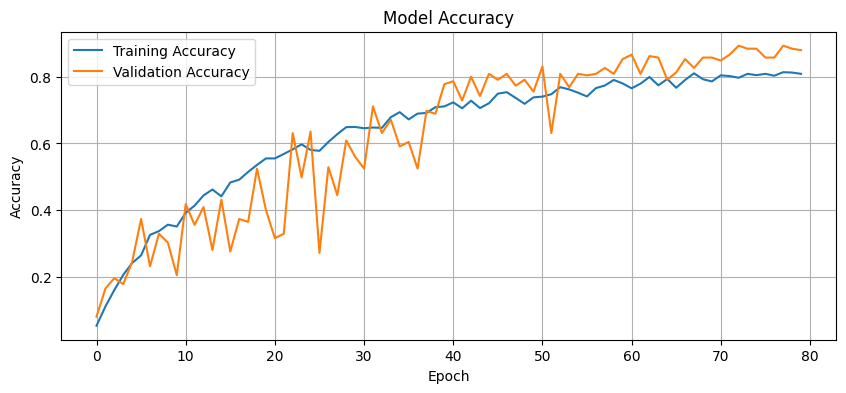

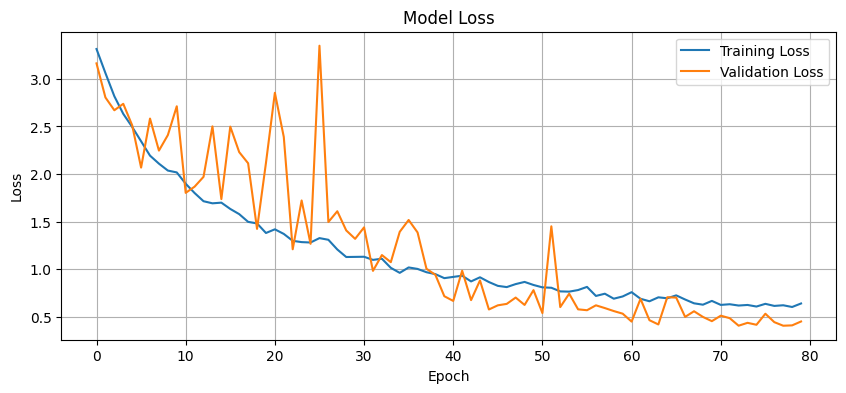

In [ ]:
import matplotlib.pyplot as plt  # Plotting

# Accuracy graph
plt.figure(figsize=(10, 4))
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import sys
print(sys.executable)


/anaconda/envs/jupyter_env/bin/python
